<a href="https://colab.research.google.com/github/datvodinh10/Cat-Dog-Classification/blob/main/Cat_Dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone and Import data

In [1]:
!git clone https://github.com/datvodinh10/Cat-Dog-Classification.git

Cloning into 'Cat-Dog-Classification'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 79 (delta 0), reused 5 (delta 0), pack-reused 70
Unpacking objects: 100% (79/79), 33.40 MiB | 6.50 MiB/s, done.


In [2]:
! pip -q install kaggle

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv /content/Cat-Dog-Classification/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!kaggle competitions download -c dog-vs-cat-classification

 99% 714M/718M [00:18<00:00, 45.7MB/s]
100% 718M/718M [00:18<00:00, 41.2MB/s]


In [5]:
import zipfile

In [6]:
!unzip -q /content/dog-vs-cat-classification.zip

## Import

In [7]:
from tqdm import tqdm
from glob import glob
from PIL import Image
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Preprocessing data and Augmentation

In [99]:
train_transform = transforms.Compose([ 
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
target_transform = transforms.Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))


In [100]:
train_data = datasets.ImageFolder('./train/train', transform=train_transform,target_transform=target_transform)

## Model

In [101]:
device

device(type='cuda', index=0)

In [102]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
class CNNModel(nn.Module):
  def __init__(self,model,train_data,batch_size=32,epochs=10,lr=2.5e-4,num_workers=4):
    super().__init__()
    self.batch_size       = batch_size
    self.epochs           = epochs
    self.lr               = lr
    self.model            = model
    self.train_len        = int(len(train_data) * 0.85)
    self.val_len          = len(train_data) - self.train_len
    train_ds,val_ds       = random_split(train_data,[self.train_len,self.val_len])
    self.train_loader     = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True,num_workers=num_workers)
    self.val_loader       = DataLoader(val_ds, batch_size=self.batch_size, shuffle=True,num_workers=num_workers)
    self.optimizer        = torch.optim.Adam(self.model.parameters(),lr=self.lr)
    self.criterion        = nn.CrossEntropyLoss()
    self.scheduler        = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,factor=0.3,patience=5)
    self.train_acc_list   = []
    self.val_acc_list     = []
    self.train_loss_list  = []
    self.val_loss_list    = []
    # self.old_state_dict   = self.model.state_dict()
    # self.old_val_loss     = 

  def predict(self,x,train_mode=True):
    if train_mode:
      self.model.train()
      return self.model.forward(x)
    else:
      self.model.eval()
      return self.model.forward(x)
  
  def predict_validate(self):
    """return y_pred and y_true for validation"""
    y_pred_val = []
    y_true = []
    with torch.no_grad():
      for i, (x,y) in enumerate(self.val_loader):
        y_true += list(y.numpy())
        x,y = x.to(device=device),y.to(device=device)
        y_pred = self.predict(x,train_mode=False)
        y_pred_val +=list(y_pred.cpu().numpy())
    # print(y_pred_val,y_true)
    # print(torch.tensor(np.array(y_true),dtype=torch.float32).shape)
    return torch.tensor(np.array(y_pred_val),dtype=torch.float32),torch.tensor(np.array(y_true),dtype=torch.float32)

  def fit(self):
    train_acc_list = []
    val_acc_list   = []
    for e in range(self.epochs):
        train_loss = 0
        train_acc = 0
        num_batch = 0
        for i, (x,y) in enumerate(self.train_loader):
            x,y = x.to(device=device),y.to(device=device)
            num_batch+=1
            y_pred = self.predict(x)
            loss = self.criterion(y_pred,y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            train_loss+=loss.detach().item()
            train_acc += torch.sum((torch.argmax(y_pred,dim=1)==torch.argmax(y,dim=1)) * 1.0)
            # print(i)
        with torch.no_grad():
            y_pred,y_true = self.predict_validate()
            val_loss          = self.criterion(y_pred,y_true)
            val_acc       = torch.mean((torch.argmax(y_pred,dim=1)==torch.argmax(y_true,dim=1)) * 1.0)
            self.scheduler.step(val_loss)

            train_loss  /= num_batch
            train_acc   /= self.train_len
            self.train_acc_list.append(train_acc.item()*100)
            self.val_acc_list.append(val_acc.item()*100)
            self.train_loss_list.append(train_loss)
            self.val_loss_list.append(val_loss)
            
            print(f'| EPOCH {e:>5} | TRAIN ACC: {train_acc* 100:.2f}% | VAL ACC: {val_acc*100:.2f}% | TRAIN LOSS: {train_loss:.4f} | VAL LOSS: {val_loss:.4f} |')

  def plot(self):
      sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
      plt.rc('axes', titlesize=18)     # fontsize of the axes title
      plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
      plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
      plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
      plt.rc('legend', fontsize=13)    # legend fontsize
      plt.rc('font', size=13)
      plt.figure(figsize=(12,6))
      plt.subplot(1,2,1)
      plt.plot(self.train_acc_list)
      plt.plot(self.val_acc_list)
      plt.legend(['Train','Val'])
      plt.xlabel('Epoch')
      plt.ylabel('% Win')
      plt.subplot(1,2,2)
      plt.plot(self.train_loss_list)
      plt.plot(self.val_loss_list)
      plt.legend(['Train','Val'])
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.show()
  
  def confusion(self):
    with torch.no_grad():
      y_pred,y_true = self.predict_validate()
      cm = confusion_matrix(torch.argmax(y_true,dim=1).cpu().numpy(), torch.argmax(y_pred,dim=1).cpu().numpy())
      cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])
      plt.figure(figsize=(10,10))
      sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=['CAT','DOG'], yticklabels=['CAT','DOG'])
  
  def report(self):
    with torch.no_grad():
      y_pred,y_true = self.predict_validate()
      print(classification_report(torch.argmax(y_true,dim=1).cpu().numpy(), torch.argmax(y_pred,dim=1).cpu().numpy(), target_names = ['CAT (Class 0)', 'DOG (Class 1)']))

## Train

In [103]:
cnn_model = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3)),
            nn.ReLU(),
            # nn.BatchNorm2d(16),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3)),
            nn.ReLU(),
            # nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3)),
            nn.ReLU(),
            # nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),
            nn.Flatten(1),
            nn.Linear(43264,128),
            nn.ReLU(),
            # nn.BatchNorm1d(128),
            nn.Dropout(p=0.4),
            nn.Linear(128,2)).to(device=device)

In [104]:
model = CNNModel(cnn_model,train_data,batch_size=50,epochs=20,lr=1e-4,num_workers=4)

In [105]:
model.fit()

| EPOCH     0 | TRAIN ACC: 60.40% | VAL ACC: 66.08% | TRAIN LOSS: 0.6531 | VAL LOSS: 0.6324 |
| EPOCH     1 | TRAIN ACC: 67.63% | VAL ACC: 70.37% | TRAIN LOSS: 0.5998 | VAL LOSS: 0.5808 |
| EPOCH     2 | TRAIN ACC: 70.18% | VAL ACC: 71.39% | TRAIN LOSS: 0.5740 | VAL LOSS: 0.5614 |
| EPOCH     3 | TRAIN ACC: 71.08% | VAL ACC: 72.29% | TRAIN LOSS: 0.5549 | VAL LOSS: 0.5501 |
| EPOCH     4 | TRAIN ACC: 72.74% | VAL ACC: 73.52% | TRAIN LOSS: 0.5378 | VAL LOSS: 0.5301 |
| EPOCH     5 | TRAIN ACC: 73.84% | VAL ACC: 71.39% | TRAIN LOSS: 0.5241 | VAL LOSS: 0.5493 |
| EPOCH     6 | TRAIN ACC: 74.80% | VAL ACC: 74.80% | TRAIN LOSS: 0.5115 | VAL LOSS: 0.5071 |
| EPOCH     7 | TRAIN ACC: 75.94% | VAL ACC: 76.91% | TRAIN LOSS: 0.4948 | VAL LOSS: 0.4804 |
| EPOCH     8 | TRAIN ACC: 76.64% | VAL ACC: 74.43% | TRAIN LOSS: 0.4855 | VAL LOSS: 0.5158 |
| EPOCH     9 | TRAIN ACC: 77.05% | VAL ACC: 74.83% | TRAIN LOSS: 0.4804 | VAL LOSS: 0.5061 |
| EPOCH    10 | TRAIN ACC: 77.64% | VAL ACC: 75.97% | TRAIN 

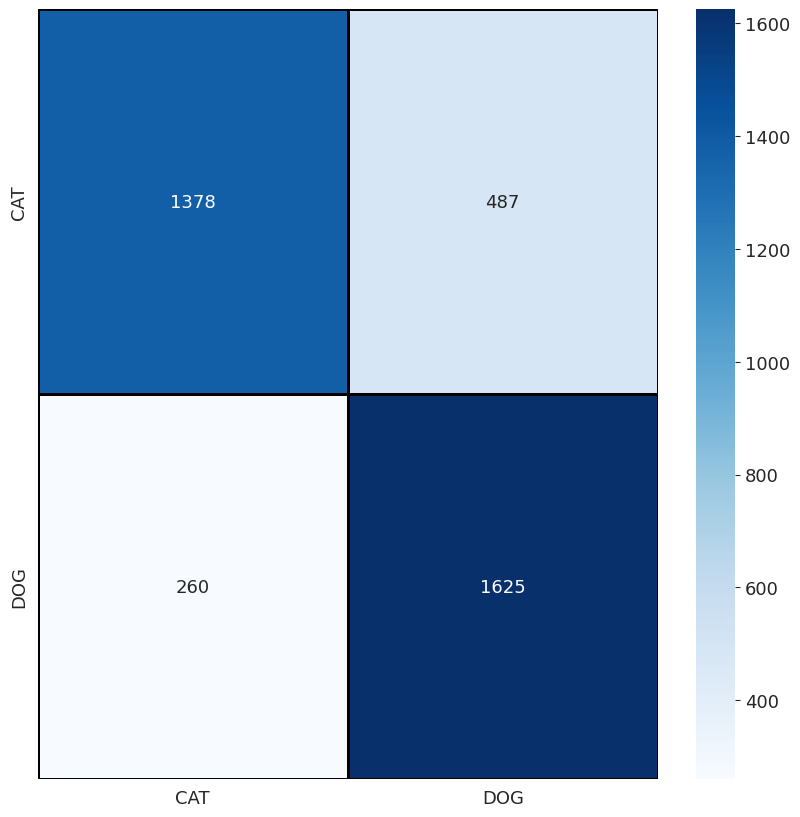

In [106]:
model.confusion()

In [107]:
model.report()

               precision    recall  f1-score   support

CAT (Class 0)       0.84      0.74      0.79      1865
DOG (Class 1)       0.77      0.86      0.81      1885

     accuracy                           0.80      3750
    macro avg       0.81      0.80      0.80      3750
 weighted avg       0.81      0.80      0.80      3750



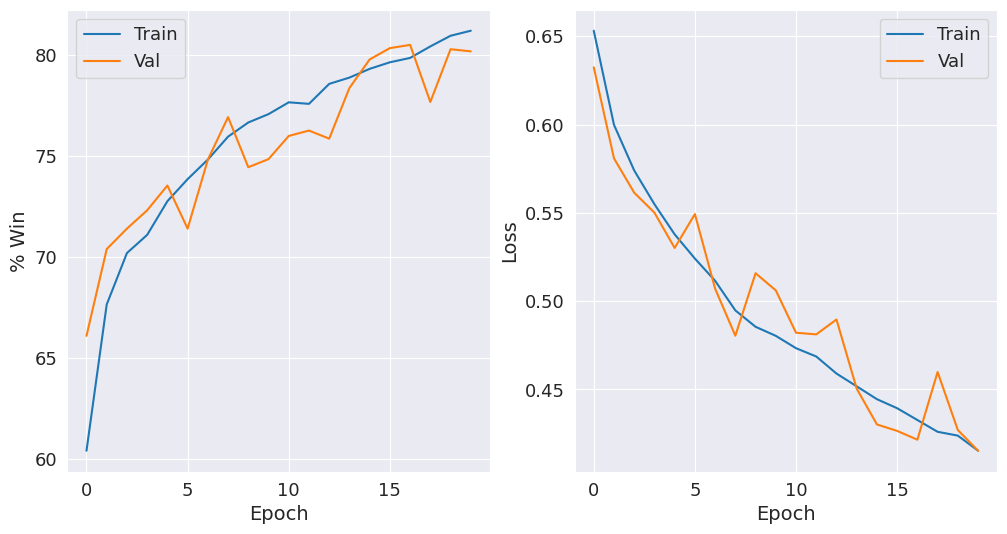

In [108]:
model.plot()